In [1]:
import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from adm.adm import ADM
from init_params import init_C
from scipy.io import savemat
import numpy as np
import time
import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from visualization.plot_funcs import *
import pickle

### Load data

In [2]:
xdima = 2 # the number of across-region latent variables (communication channel)
xdimw = 2 # the number of within-region latent variables
lr = 5e-3 # learning rate
num_iters = 300 # the number of training epochs
lag = 4 # the number of SSM order for across-region latent variables
eps = 1e-4 # a small constant for numerical stability

with open('./data/demo_v1v2_data.pkl', 'rb') as f:
    data = pickle.load(f)
    V1 = data["V1"]
    V2 = data["V2"]
    y = np.concatenate((V1, V2), axis=2).astype(np.float32)

ydims = [V1.shape[-1], V2.shape[-1]]

num_trials, T, ydim = y.shape

dtype = torch.float32
device = "cuda" if torch.cuda.is_available() else "cpu"
fig_dir = "./res/"

# Training settings
num_repeat = 3
batch_size = num_trials

y = torch.tensor(y, dtype=dtype, device=device)

In [3]:
delays_runs = np.zeros((num_repeat, T, len(ydims)-1, xdima)) 
train_losses_runs = []
val_losses_runs = []
pred_xs_runs = []
pred_ys_runs = []
true_ys_runs = []
true_ys_train_record_runs = []
pred_ys_train_record_runs = []
avg_test_loss_runs = []
test_lls = []

num_train = 200
num_val = 100
num_test = 100

indices = np.arange(num_trials)
train_indices = torch.tensor(indices[0:num_train], dtype=torch.int, device=device)
val_indices = torch.tensor(indices[num_train:num_train + num_val], dtype=torch.int, device=device)
test_indices = torch.tensor(indices[num_train + num_val:], dtype=torch.int, device=device)

y_train = y[train_indices]
y_val = y[val_indices]
y_test = y[test_indices]

train_dataset = TensorDataset(y_train)
val_dataset = TensorDataset(y_val)
test_dataset = TensorDataset(y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### Training and Analyzing Results

In [4]:
for run in range(num_repeat):
    print(f"\n=== Run {run+1}/{num_repeat} ===")
    run_times = []
    train_losses = []
    val_losses = []
    test_losses = []
    start_time = time.time()

    # Initialize model and optimizer
    model = ADM(lag, xdima, xdimw, ydims, T, eps, device, dtype=dtype).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_iters)


    y_train_np = y_train.detach().cpu().numpy().transpose(2, 1, 0)
    y_train_np_reshape = np.mean(y_train_np, axis=-1)
    # y_train_np_reshape = np.reshape(y_train_np, (ydim, T * y_train_np.shape[-1]), order="C")
    Cs, diag_Rs = init_C(y_train_np_reshape, len(ydims), xdima, xdimw, ydims, 0.1, device, dtype)
    model.Cs = Cs
    model.diag_Rs = diag_Rs

    model.train()

    best_val_loss = np.inf
    best_model_state = None
    
    # Training and validation loop
    with torch.autograd.set_detect_anomaly(False):
        with tqdm.tqdm(np.arange(num_iters), disable=False, mininterval=0.5) as bar:
            for epoch in bar:
                bar.set_description(f"Epoch {epoch}")
                avg_train_loss = 0.0
                avg_val_loss = 0.0
                pred_xs_train = []
                true_ys_train = []
                for y_batch in train_loader:
                    optimizer.zero_grad()
                    train_loss, pred_x = model.forward(y_batch[0])
                    pred_xs_train.append(pred_x)
                    true_ys_train.append(y_batch[0])
                    train_loss.backward()
                    avg_train_loss += train_loss.item()
                    optimizer.step()

                with torch.no_grad():
                    y_batch_all = torch.cat(true_ys_train, dim=0)
                    x_batch_all = torch.cat(pred_xs_train, dim=0)
                    pred_y, pred_x = model.update_C_and_R(y_batch_all, x_batch_all)
                    
                scheduler.step()

                avg_train_loss /= len(train_loader)
                train_losses.append(avg_train_loss)

                cur_lr = [param_group['lr'] for param_group in optimizer.param_groups]

                bar.set_postfix(
                    loss=f"{avg_train_loss:.3f}",
                    lr=f"{cur_lr[0]:.3f}"
                )

                # Validation loop
                model.eval()  
                with torch.no_grad(): 
                    for y_batch in val_loader:
                        val_loss, _ = model.forward(y_batch[0])
                        avg_val_loss += val_loss.item()
                avg_val_loss /= len(val_loader) 
                val_losses.append(avg_val_loss)

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_model_state = model.state_dict()
                    best_Cs = model.Cs
                    best_diag_R = model.diag_Rs
                    best_ds = model.ds

                model.train()  # Switch back to training mode

    end_time = time.time()
    run_times.append((end_time - start_time) / 60)

    # Save the model
    file_name = f"adm_xdima_{xdima}_xdimw_{xdimw}_{time.strftime('%Y%m%d-%H%M%S')}"
    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), f'./states/{file_name}.pth')
    model.Cs = best_Cs
    model.diag_Rs = best_diag_R
    model.ds = best_ds

    Cs = []
    for i in range(len(model.Cs)):
        Cs.append(model.Cs[i].detach().cpu().numpy())
    savemat(f'./states/{file_name}.mat', {"Cs":Cs, "diag_R":model.diag_Rs.detach().cpu().numpy(),"d":model.ds.detach().cpu().numpy()})

    model.eval()  # Set model to evaluation mode for testing
    with torch.no_grad():
        for i in range(xdima):
            d = model.across_dynamics[i].get_delays()        
            delays_runs[run, :, :, i] = d.detach().cpu().numpy()
    
    pred_xs_train = []
    true_ys_train = []
    pred_ys_train = []
    with torch.no_grad():
        _, pred_x = model.forward(y_train)
        pred_y, pred_x_shift = model.update_ys(pred_x)
    pred_xs_train_record = pred_x_shift.detach().cpu().numpy()
    pred_ys_train_record = pred_y.detach().cpu().numpy()
    true_ys_train_record = y_train.detach().cpu().numpy()

    with torch.no_grad():
        test_loss, pred_x = model.forward(y_test)
        pred_y, pred_x_shift = model.update_ys(pred_x)
        Cs = torch.block_diag(*model.Cs) @ model.H
        Rs = torch.diag(model.diag_Rs)
        avg_test_loss = test_loss.item()
        test_ll = model.log_likelihood_observation(pred_x.squeeze(-1), y_test - model.ds, Cs, Rs)

    test_lls.append(test_ll.item())
    pred_xs = pred_x_shift.detach().cpu().numpy()
    pred_ys = pred_y.detach().cpu().numpy()
    true_ys = y_test.detach().cpu().numpy()

    avg_test_loss_runs.append(avg_test_loss)
    train_losses_runs.append(train_losses)
    val_losses_runs.append(val_losses)
    pred_xs_runs.append(pred_xs)
    pred_ys_runs.append(pred_ys)
    true_ys_runs.append(true_ys)
    true_ys_train_record_runs.append(true_ys_train_record)
    pred_ys_train_record_runs.append(pred_ys_train_record)

print(f"Test observation LL: {np.around(np.mean(test_lls), 2)} ± {np.around(np.std(test_lls), 2)}")



=== Run 1/3 ===


Epoch 299: 100%|██████████| 300/300 [01:17<00:00,  3.89it/s, loss=-41141888.000, lr=0.000]



=== Run 2/3 ===


Epoch 299: 100%|██████████| 300/300 [00:42<00:00,  7.05it/s, loss=-40808388.000, lr=0.000]



=== Run 3/3 ===


Epoch 299: 100%|██████████| 300/300 [00:37<00:00,  7.96it/s, loss=-40005152.000, lr=0.000]


Test observation LL: 29248.28 ± 70.45


### Ploting results

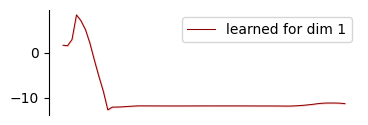

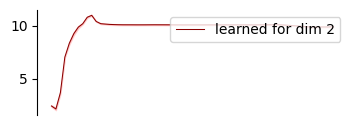

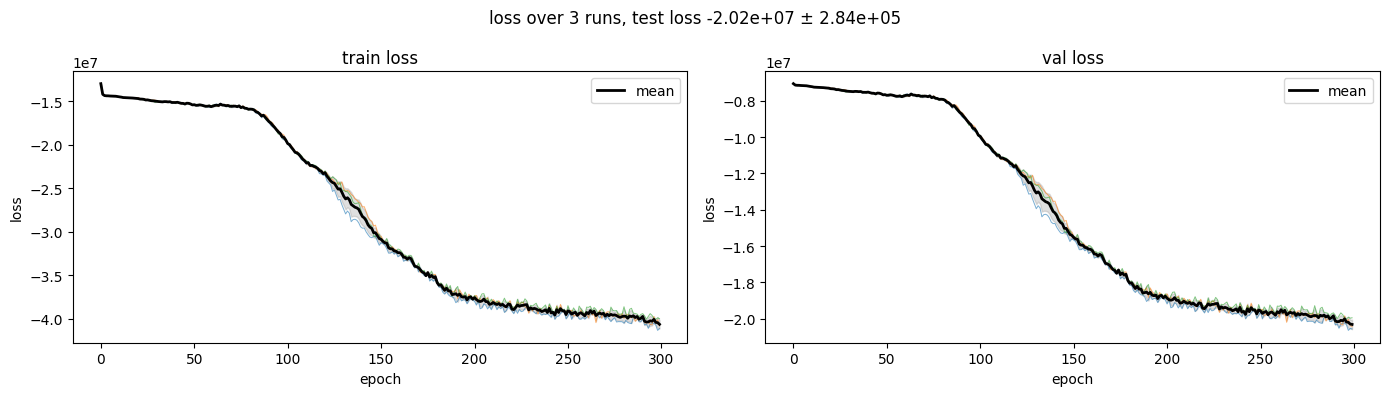

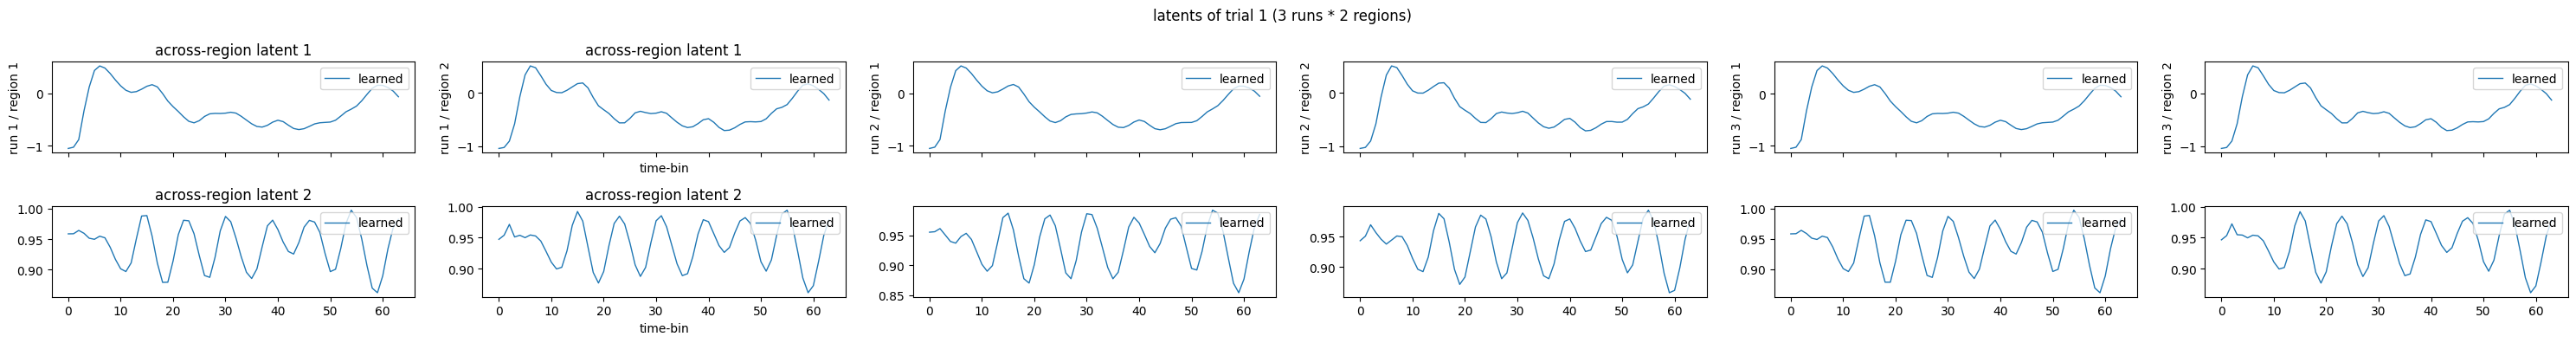

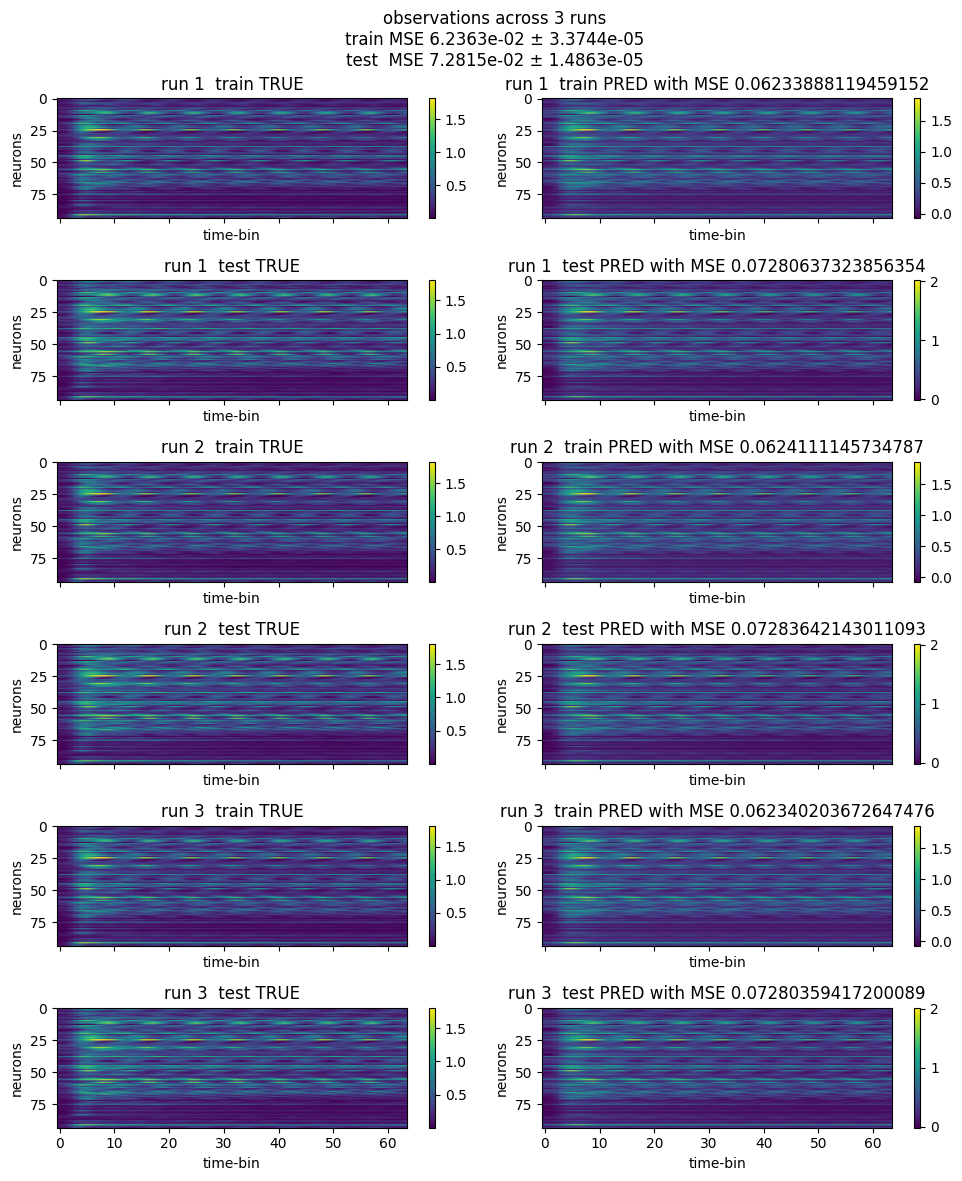

In [ ]:
if xdima > 0:
    fig = plot_delay(delays_runs, None, xdima, ydims, fig_dir, file_name, binsize=20)

# plot loss curve
fig = plot_loss(train_losses_runs, val_losses_runs, avg_test_loss_runs, fig_dir, file_name)

# plot estimated latent variables
fig = plot_latent(pred_xs_runs, None, xdima, xdimw, ydims, fig_dir, file_name)
 
# plot predicted observations
fig = plot_observation(pred_ys_runs, true_ys_runs, pred_ys_train_record_runs, true_ys_train_record_runs, fig_dir, file_name)
